In [18]:
import os, random, math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
%matplotlib inline

In [10]:
import lightgbm as lgb

//anaconda/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [12]:
import librosa
import librosa.display

In [13]:
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split

In [21]:
from prettytable import PrettyTable
from tqdm import tqdm_notebook, tqdm_pandas
tqdm_notebook().pandas(smoothing = 0.7)

In [20]:
import IPython
import IPython.display as ipd

## Starting Audio Parsing

In [26]:
test = pd.read_csv("all/sample_submission.csv")
train = pd.read_csv("all/train.csv")
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [36]:
n_test = test.shape[0]
n_train = train.shape[0]
print('Number of training examples: {}'.format(n_train))
print('Number of testing examples: {}'.format(n_test))
print('Number of unique categories: {}'.format(train['label'].nunique()))

Number of training examples: 9473
Number of testing examples: 9400
Number of unique categories: 41


In [37]:
# keep in mind that not all labels are verified!

In [38]:
def play_audio(wavfile, dset='train'):
    print(wavfile)
    file_name = 'all/audio_{}/{}'.format(dset, wavfile)
    IPython.display.display(ipd.Audio(file_name))
    
    x, sr = librosa.load(file_name)
    
    plt.figure(figsize=(14,5))
    librosa.display.waveplot(x, sr=sr)
    X=librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14,5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis = 'hz')

Hi-hat
15b6657d.wav


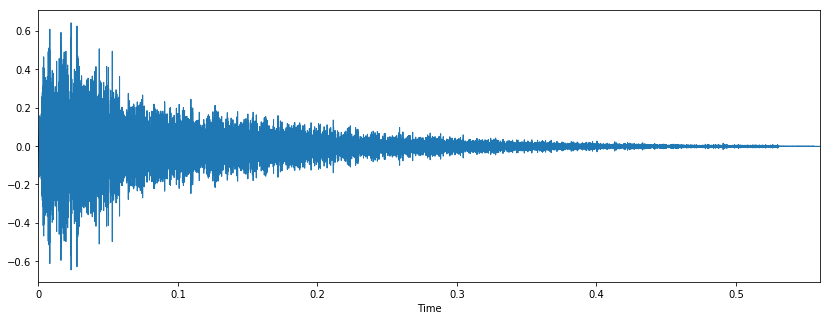

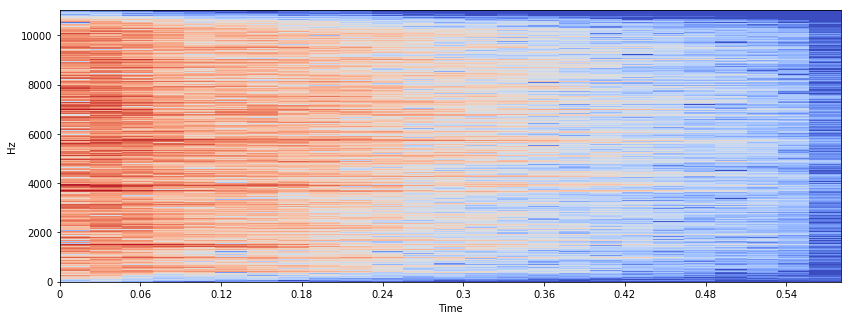

In [42]:
random_int = random.randint(0, n_train)
random_wavfile = train.fname.iloc[random_int]
print(train.label.iloc[random_int])
play_audio(random_wavfile)

In [43]:
# a single audio file only has one lable associated to it

## Starting with Basic Feature Engineering

In [53]:
def wavefile_stats(fname, root):
    try:
        data, fs = librosa.core.load(root + fname, sr=None)
        mean = np.mean(data)
        minimum = np.min(data)
        maximum = np.max(data)
        std = np.std(data)
        length = len(data)
        rms = np.sqrt(np.mean(data**2))
        skewness = skew(data) # shape of the distribution of the data
        kurt = kurtosis(data) # shape of the distribution of the data
        
        return pd.Series([length, mean, minimum, maximum, std, rms, skewness, kurt])
    except ValueError:
        print("Bad file at {}".format(fname))
        return pd.Series([0,0,0,0,0,0,0])

In [54]:
# takes around 5 min to run!
train_root = 'all/audio_train/'
train[['length', 'mean', 'min', 'max', 'std', 'rms', 'skewness', 'kurtosis']] = \
    train['fname'].progress_apply(wavefile_stats, root=train_root)

In [55]:
# takes around 5 min to run!
test_root = 'all/audio_test/'
test[['length', 'mean', 'min', 'max', 'std', 'rms', 'skewness', 'kurtosis']] = \
    test['fname'].progress_apply(wavefile_stats, root=test_root)

//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Bad file at 0b0427e2.wav
Bad file at 6ea0099f.wav
Bad file at b39975f5.wav


In [56]:
# adding manual features
train['rms_std'] = train['rms']/train['std']
test['rms_std'] = test['rms']/test['std']

train['max_min'] = train['max']/train['min']
test['max_min'] = test['max']/test['min']

In [62]:
# viewing data via plots

def plot_hist(feature_name, bins=50, log=False):
    data = train[feature_name].values
    plt.hist(data, bins=bins, log=log)
    plt.grid()
    plt.show()
    
def plot_box(feature_name):
    props = dict(linewidth = 3)
    train.boxplot(column=feature_name, by='label', rot=90, figsize=(20,7),
                 sym='', grid=False, boxprops=props)
    plt.title('{} boxplot'.format(feature_name))
    plt.suptitle('')

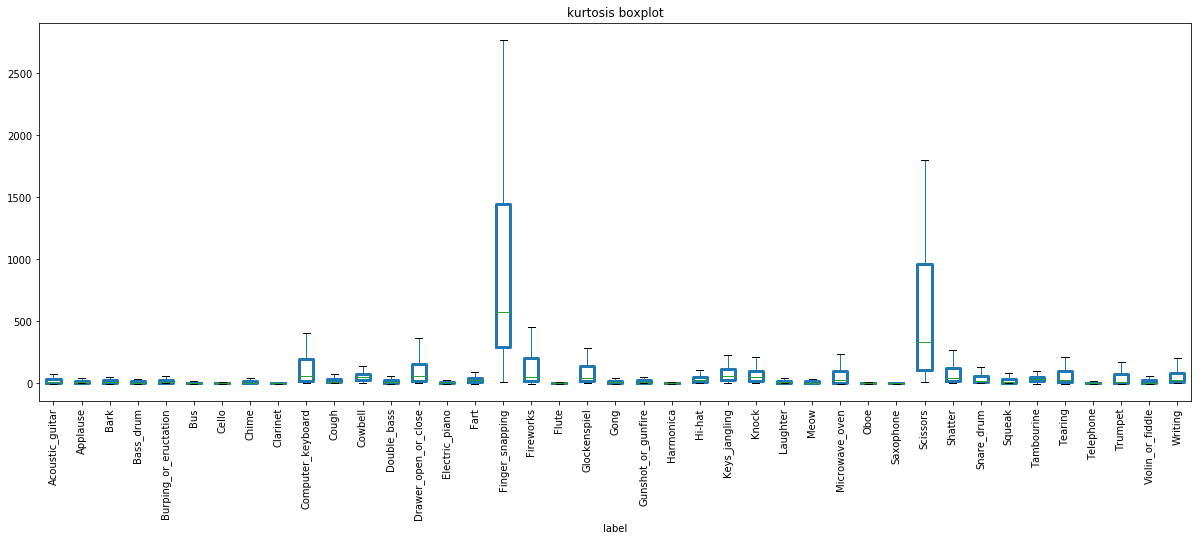

In [65]:
feature='kurtosis'
plot_box(feature)

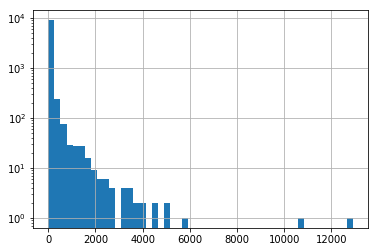

In [66]:
plot_hist(feature, log=True)

### Removal of NaNs

In [67]:
test[pd.isnull(test).any(axis=1)].head()

,fname,label,length,mean,min,max,std,rms,skewness,kurtosis,rms_std,max_min
388,0b0427e2.wav,Laughter Hi-Hat Flute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4009,6ea0099f.wav,Laughter Hi-Hat Flute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
6603,b39975f5.wav,Laughter Hi-Hat Flute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [68]:
test.fillna(0, inplace=True)

## Splitting data into train/test

In [75]:
def data_split(train, test, shuffle=True, test_size=0.25, random_state=0, verbose=True):
    X_train = train.drop(['fname', 'label', 'manually_verified'], axis=1).values
    X_test = test.drop(['fname', 'label'], axis=1).values
    feature_names = list(test.drop(['fname', 'label'], axis=1).columns.values)
    
    y_train = pd.get_dummies(train.label)
    labels = y_train.columns.values
    y_train = y_train.values
    
    y_train = [np.argmax(row) for row in y_train]
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size,
                                                         random_state=random_state, shuffle= shuffle)
    if verbose:
        print("Train X shape = {}\nTrain y shape = {}".format(X_train.shape, len(y_train)))
        print("\nValid X shape = {}\nValid y shape = {}".format(X_valid.shape, len(y_valid)))
    assert X_train.shape[1] == X_valid.shape[1] == X_test.shape[1]
    assert len(y_train) == X_train.shape[0]
    assert len(y_valid) == X_valid.shape[0]
    
    return X_train, X_valid, y_train, y_valid, X_test, feature_names, labels

In [76]:
X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = data_split(train,test)

Train X shape = (7104, 10)
Train y shape = 7104

Valid X shape = (2369, 10)
Valid y shape = 2369


In [77]:
# WE CAN TRY TO ATTEMPT TO STRATEFY OUR CLASSES

In [81]:
# preparing the dataset for LightGBM
def lgb_dset(X_train, X_valid, y_train, y_valid, feature_names):
    d_train = lgb.Dataset(X_train, label=y_train, feature_name = feature_names)
    d_valid = lgb.Dataset(X_valid, label=y_valid, feature_name = feature_names)
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'max_depth': 5,
        'num_leaves': 31,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'num_threads': os.cpu_count(),
        'lambda_l2': 1.0,
        'min_gain_to_split': 0,
        'num_class': 41
    }
    return d_train, d_valid, params

In [82]:
# training the first model using LightGBM
# takes a few min to run!
d_train, d_valid, params = lgb_dset(X_train, X_valid, y_train, y_valid, feature_names)
clf = lgb.train(params, d_train, 500, d_valid, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 2.64592
[200]	valid_0's multi_logloss: 2.48024
[300]	valid_0's multi_logloss: 2.42706
[400]	valid_0's multi_logloss: 2.4095
[500]	valid_0's multi_logloss: 2.40593
Did not meet early stopping. Best iteration is:
[464]	valid_0's multi_logloss: 2.4046


** IMPORTANT: ** If choose to use the loss function from the competition, we need to output top 3 most likely labels and the loss function is calculated based on the three of them

In [85]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]
        
    score = 0.0
    num_hits = 0.0
    
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits /(i+1.0)
            
            
    if not actual:
        return 0.0
    
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [93]:
p = clf.predict(X_valid, num_iteration = clf.best_iteration)

predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]
actual = [[i] for i in y_valid]

valid_score = mapk(actual, predictions, k=3)

print('Score = {:.4f}'.format(valid_score))

Score = 0.4483


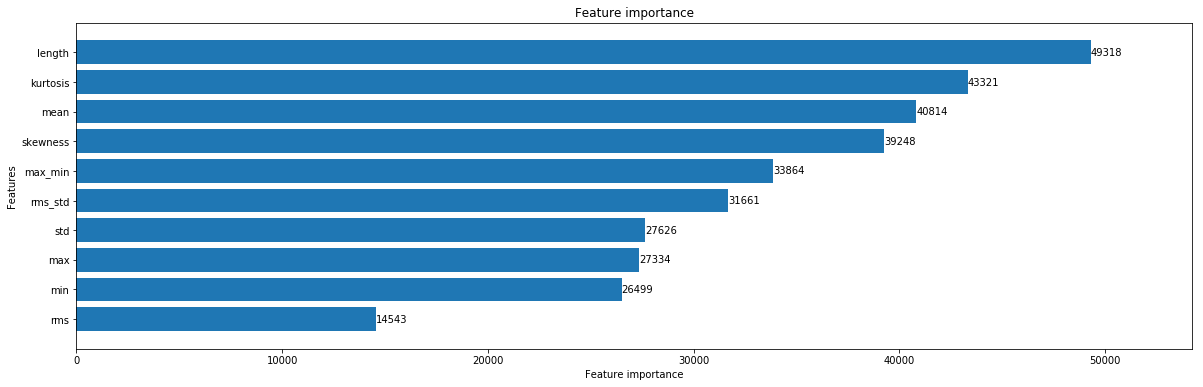

In [88]:
# Show feature importances
ax = lgb.plot_importance(clf, max_num_features=10, grid=False, height=0.8, figsize=(20,6))
plt.show()

In [95]:
# look at the current predictions

def preds_to_labels(p,labels):
    predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]
    prediction_labels = []
    
    for pred in predictions:
        label_list = []
        for output in pred:
            label_list.append(labels[output])
        prediction_labels.append(label_list)
    return prediction_labels

lab = preds_to_labels(p, labels)

t = PrettyTable(['Truth', 'Prediction'])
[t.add_row([labels[l[1][0]], l[0]]) for l in zip(lab[:10], actual[:10])]
print(t)

+----------------------+---------------------------------------------------+
|        Truth         |                     Prediction                    |
+----------------------+---------------------------------------------------+
|      Fireworks       |    ['Fireworks', 'Gunshot_or_gunfire', 'Knock']   |
|    Electric_piano    | ['Acoustic_guitar', 'Applause', 'Electric_piano'] |
|         Gong         |    ['Applause', 'Acoustic_guitar', 'Laughter']    |
|       Shatter        |  ['Fireworks', 'Drawer_open_or_close', 'Writing'] |
| Drawer_open_or_close |          ['Shatter', 'Fireworks', 'Meow']         |
|         Gong         |            ['Gong', 'Bark', 'Applause']           |
|      Saxophone       |         ['Oboe', 'Double_bass', 'Trumpet']        |
|       Tearing        |        ['Applause', 'Tearing', 'Fireworks']       |
|      Saxophone       |       ['Saxophone', 'Trumpet', 'Bass_drum']       |
|       Applause       |      ['Applause', 'Gong', 'Acoustic_guitar']      |

In [96]:
# predicting test set
preds = clf.predict(X_test, num_iterations=clf.best_iteration)
lab = preds_to_labels(preds, labels)

['Bass_drum', 'Burping_or_eructation', 'Snare_drum']
a728974a.wav


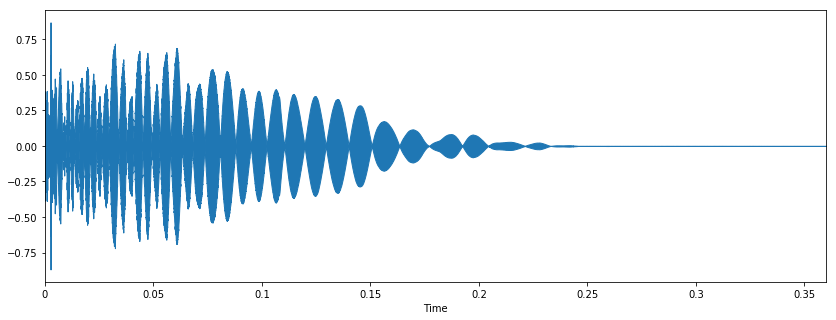

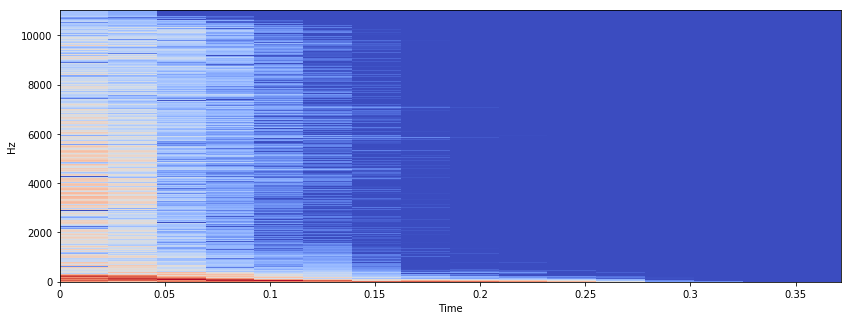

In [98]:
# spot checking
random_int = random.randint(0, n_test)
random_wavfile = test.fname.iloc[random_int]
print(lab[random_int])
play_audio(test.fname.iloc[random_int], dset='test')

In [99]:
## Applying Silence Trimming

In [102]:
def trim_silence(fname, root, window_length=0.5):
    try:
        trimmed_ends = 0
        trimmed_int = 0
        
        data, fs = librosa.core.load(root +fname, sr=None)
        length = len(data)
        # trimming silcence in the end
        data, _ = librosa.effects.trim(data, top_db=40)
        length_int = len(data)
        ratio_int = length_int / length
        # splitting into the non-silent chunks and recombine
        splits = librosa.effects.split(data, top_db=40)
        if len(splits) > 1:
            data = np.concatenate([data[x[0]:x[1]] for x in splits])
            
        length_final = len(data)
        ratio_final = length_final / length_int
        
        return pd.Series([length_int, length_final, ratio_int, ratio_final])
    except ValueError:
        print('Bad file as {}'.format(fname))
        return pd.Series([0,0,0,0])

In [103]:
# takes a little while to calculate and parse
train[['length_int', 'length_final', 'ratio_int', 'ratio_final']] = \
    train['fname'].progress_apply(trim_silence, root=train_root)
test[['length_int', 'length_final', 'ratio_int', 'ratio_final']] = \
    test['fname'].progress_apply(trim_silence, root=test_root)

Bad file as 0b0427e2.wav
Bad file as 6ea0099f.wav
Bad file as b39975f5.wav


In [108]:
trimmed_ends = 100*train.ratio_final[train.ratio_final <1.0].count()/len(train.index)
trimmed_int = 100*train.ratio_int[train.ratio_int <1.0].count()/len(train.index)

trimmed_ends_test = 100*test.ratio_final[test.ratio_final <1.0].count()/len(test.index)
trimmed_int_test = 100*test.ratio_int[test.ratio_int <1.0].count()/len(test.index)

t = PrettyTable(['Dataset', 'Ends Trimmed', 'Intermediate Trimmed'])
t.add_row(['Training', '{:.1f}%'.format(trimmed_ends), '{:.1f}%'.format(trimmed_int)])
t.add_row(['Testing', '{:.1f}%'.format(trimmed_ends_test), '{:.1f}%'.format(trimmed_int_test)])
print(t)

+----------+--------------+----------------------+
| Dataset  | Ends Trimmed | Intermediate Trimmed |
+----------+--------------+----------------------+
| Training |    36.2%     |        76.8%         |
| Testing  |    29.8%     |        79.9%         |
+----------+--------------+----------------------+


## Using MFCC (Mel Frequency)